**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

ModuleNotFoundError: No module named 'sklearn'

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.17.0'

In [4]:
keras.__version__

'3.4.1'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [6]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [7]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [8]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

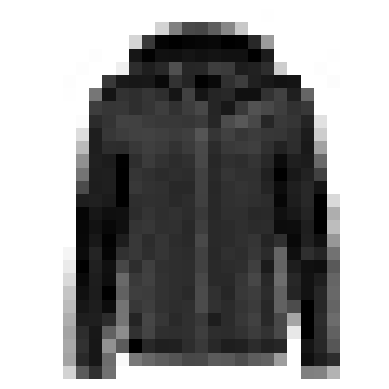

In [9]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [10]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [12]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [13]:
X_valid.shape

(5000, 28, 28)

In [14]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


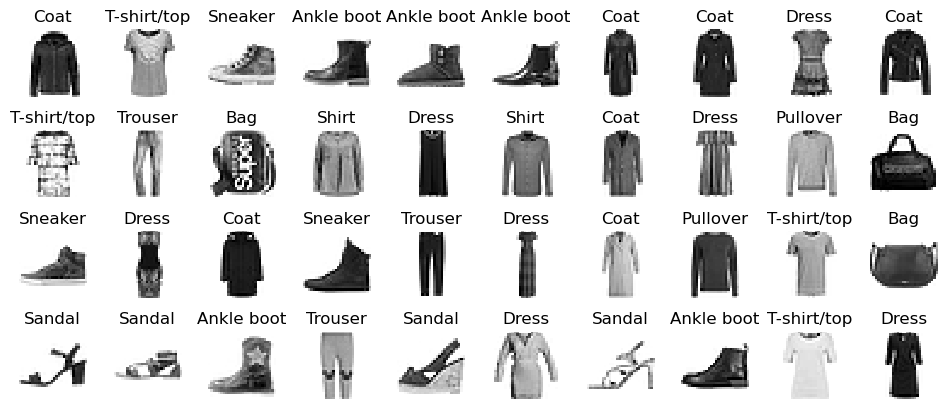

In [15]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

C:\Users\SchallerG\AppData\Local\anaconda3\envs\UniBe2024\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

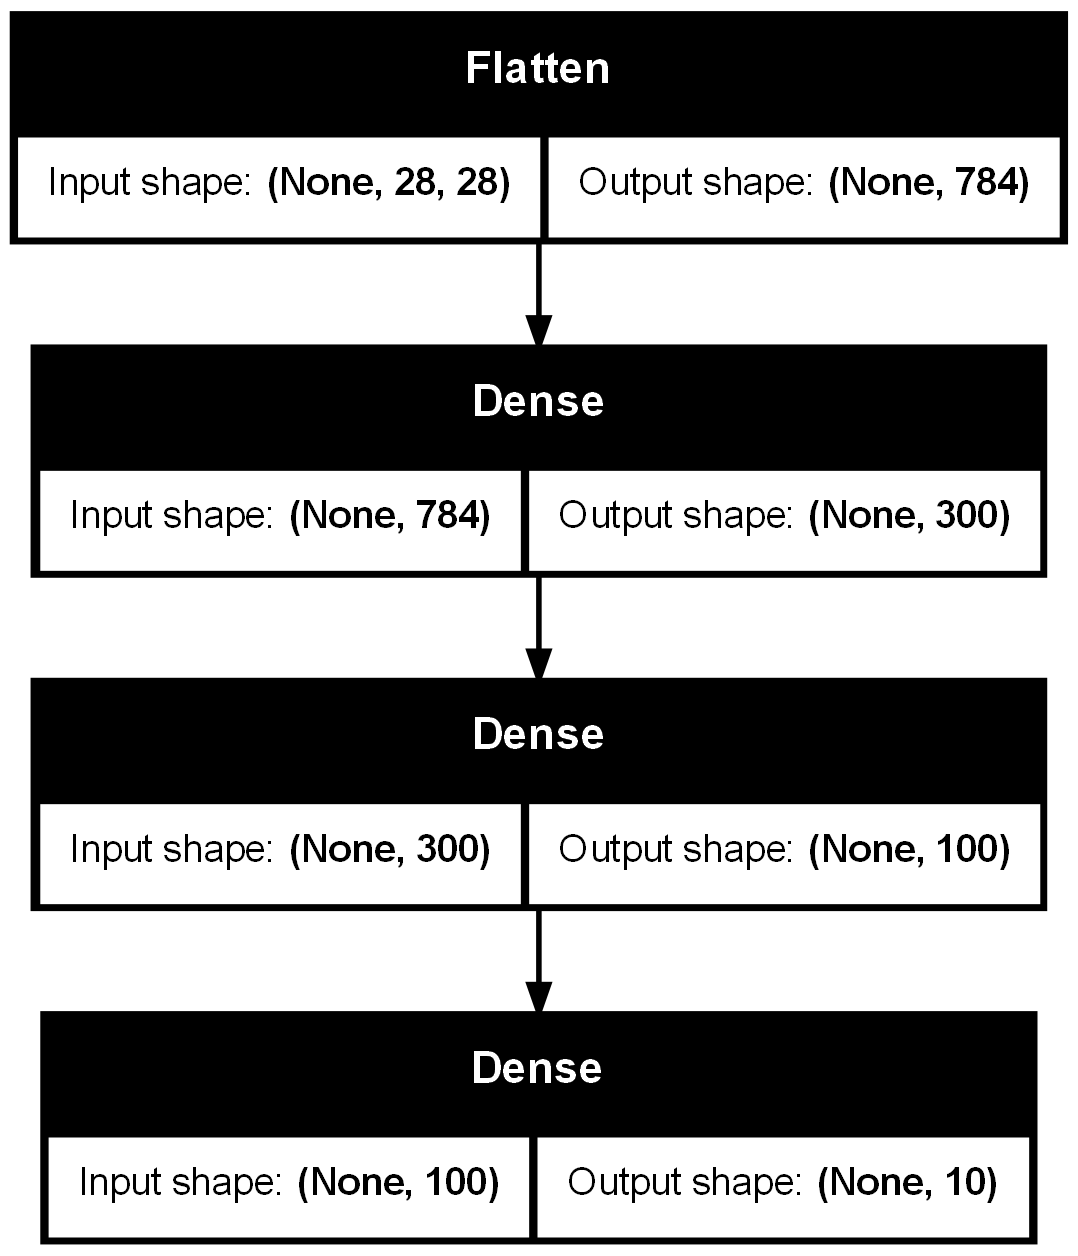

In [20]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [21]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [22]:
model.get_layer(hidden1.name) is hidden1

True

In [23]:
weights, biases = hidden1.get_weights()

In [24]:
weights

array([[-0.01136579, -0.02163126, -0.02906936, ...,  0.00296818,
         0.00596029, -0.03931893],
       [ 0.01894821, -0.02509378,  0.04838502, ...,  0.06010456,
         0.04240274, -0.02082007],
       [-0.07262903,  0.00569447,  0.00964125, ...,  0.05572593,
        -0.02348332, -0.02346938],
       ...,
       [-0.04077427,  0.04130972, -0.01667115, ..., -0.07310385,
         0.02620701,  0.00405461],
       [ 0.02200895,  0.01856788, -0.0221093 , ...,  0.03040699,
        -0.01077213,  0.06753916],
       [-0.01645658, -0.01005922, -0.06041187, ..., -0.05578369,
         0.06509876, -0.0196896 ]], dtype=float32)

In [25]:
weights.shape

(784, 300)

In [26]:
biases.shape

(300,)

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [28]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6962 - loss: 0.9695 - val_accuracy: 0.8198 - val_loss: 0.5164
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8262 - loss: 0.4976 - val_accuracy: 0.8454 - val_loss: 0.4529
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8423 - loss: 0.4445 - val_accuracy: 0.8536 - val_loss: 0.4221
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8541 - loss: 0.4144 - val_accuracy: 0.8618 - val_loss: 0.3990
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8609 - loss: 0.3931 - val_accuracy: 0.8672 - val_loss: 0.3836
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8668 - loss: 0.3764 - val_accuracy: 0.8698 - val_loss: 0.3719
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8703 - loss: 0.3629 - val_accuracy: 0.8728 - val_loss: 0.3617
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8740 - loss: 0.3515 -

In [29]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [30]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Saving figure keras_learning_curves_plot


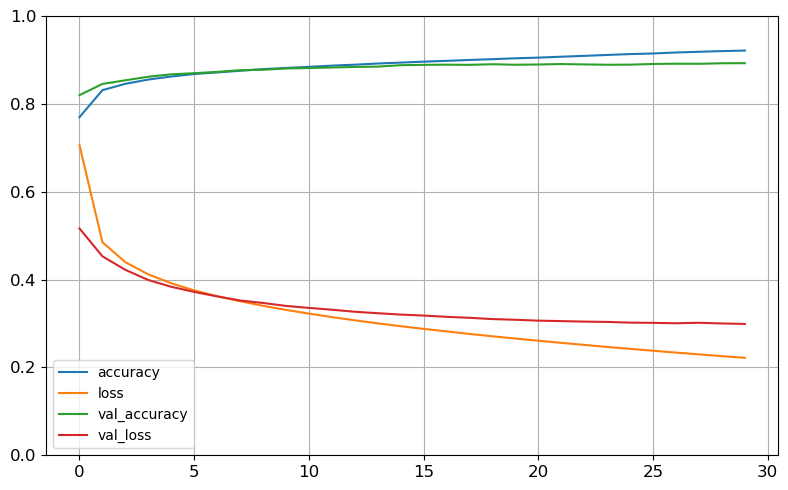

In [32]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [33]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8760 - loss: 0.3468


[0.34288662672042847, 0.8805000185966492]

In [34]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [35]:
y_pred=model.predict(X_new) 
y_pred=np.argmax(y_pred,axis=1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


array([9, 2, 1], dtype=int64)

In [36]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [37]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


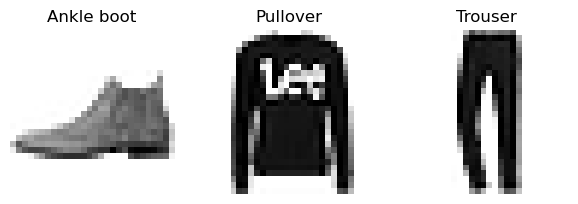

In [38]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [39]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.8725 - val_loss: 0.9016
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8523 - val_loss: 0.6463
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6774 - val_loss: 0.5790
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6169 - val_loss: 0.5422
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5807 - val_loss: 0.5153
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5547 - val_loss: 0.4938
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5347 - val_loss: 0.4766
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5186 - val_loss: 0.4622
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5053 - val_loss: 0.4504
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4941 - val_loss: 0.4406
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4845 - val_loss: 0.4324
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

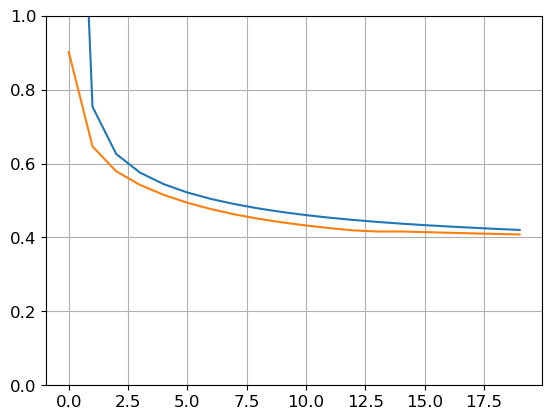

In [43]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [44]:
y_pred

array([[0.68372154],
       [1.7360501 ],
       [3.3090425 ]], dtype=float32)

# Saving and Restoring

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [52]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4755 - val_loss: 0.4560
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4650 - val_loss: 0.4526
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4562 - val_loss: 0.4507
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4488 - val_loss: 0.4499
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4425 - val_loss: 0.4494
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4372 - val_loss: 0.4491
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4325 - val_loss: 0.4483
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4283 - val_loss: 0.4475
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4245 - val_loss: 0.4463
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4212 - val_loss: 0.4449
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4068


In [53]:
model.save("my_keras_model.h5")

In [54]:
model = keras.models.load_model("my_keras_model.h5")
#model = keras.models.load_model("my_keras_model.h5", compile=False)


In [55]:
model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


array([[0.6983286],
       [1.6634815],
       [3.4780145]], dtype=float32)

In [57]:
model.save_weights("my_keras_weights.weights.h5")

In [59]:
model.load_weights("my_keras_weights.weights.h5")